# Introduction
## Problem statement 
A US-based housing company named Surprise Housing has decided to enter the Australian market. The company uses data analytics to purchase houses at a price below their actual values and flip them on at a higher price. For the same purpose, the company has collected a data set from the sale of houses in Australia.

The company wants to know:

1. Which variables are significant in predicting the price of a house, and
2. How well those variables describe the price of a house.

## Business goal
You are required to model the price of houses with the available independent variables. This model will then be used by the management to understand how exactly the prices vary with the variables. They can accordingly manipulate the strategy of the firm and concentrate on areas that will yield high returns. Further, the model will be a good way for management to understand the pricing dynamics of a new market. 

## Assignment
Please visit [my github](https://github.com/cuonghv0298/Advanced-Regression.git) for all information you need.

In [1]:
# Importing the required libraries
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import missingno as msno
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from sklearn.feature_selection import RFE
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Data Understanding

In [21]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    
    """
    Returns the names of categorical, numerical, and categorical but cardinal variables in the dataset.
    Note: Numerical-looking categorical variables are also included in the categorical variables.

    Parameters
    ------
        dataframe: dataframe
                The dataframe for which variable names are to be obtained.
        cat_th: int, optional
                Class threshold value for numerical but categorical variables.
        car_th: int, optional
                Class threshold value for categorical but cardinal variables.

    Returns
    ------
        cat_cols: list
                List of categorical variables.
        num_cols: list
                List of numerical variables.
        cat_but_car: list
                List of categorical but cardinal variables.
        num_but_cat: list 
                List of categorical but numerical variables.

    """

    # cat_cols, cat_but_car
    
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    
    return cat_cols, num_cols, cat_but_car

In [3]:
df = pd.read_csv('data/train.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

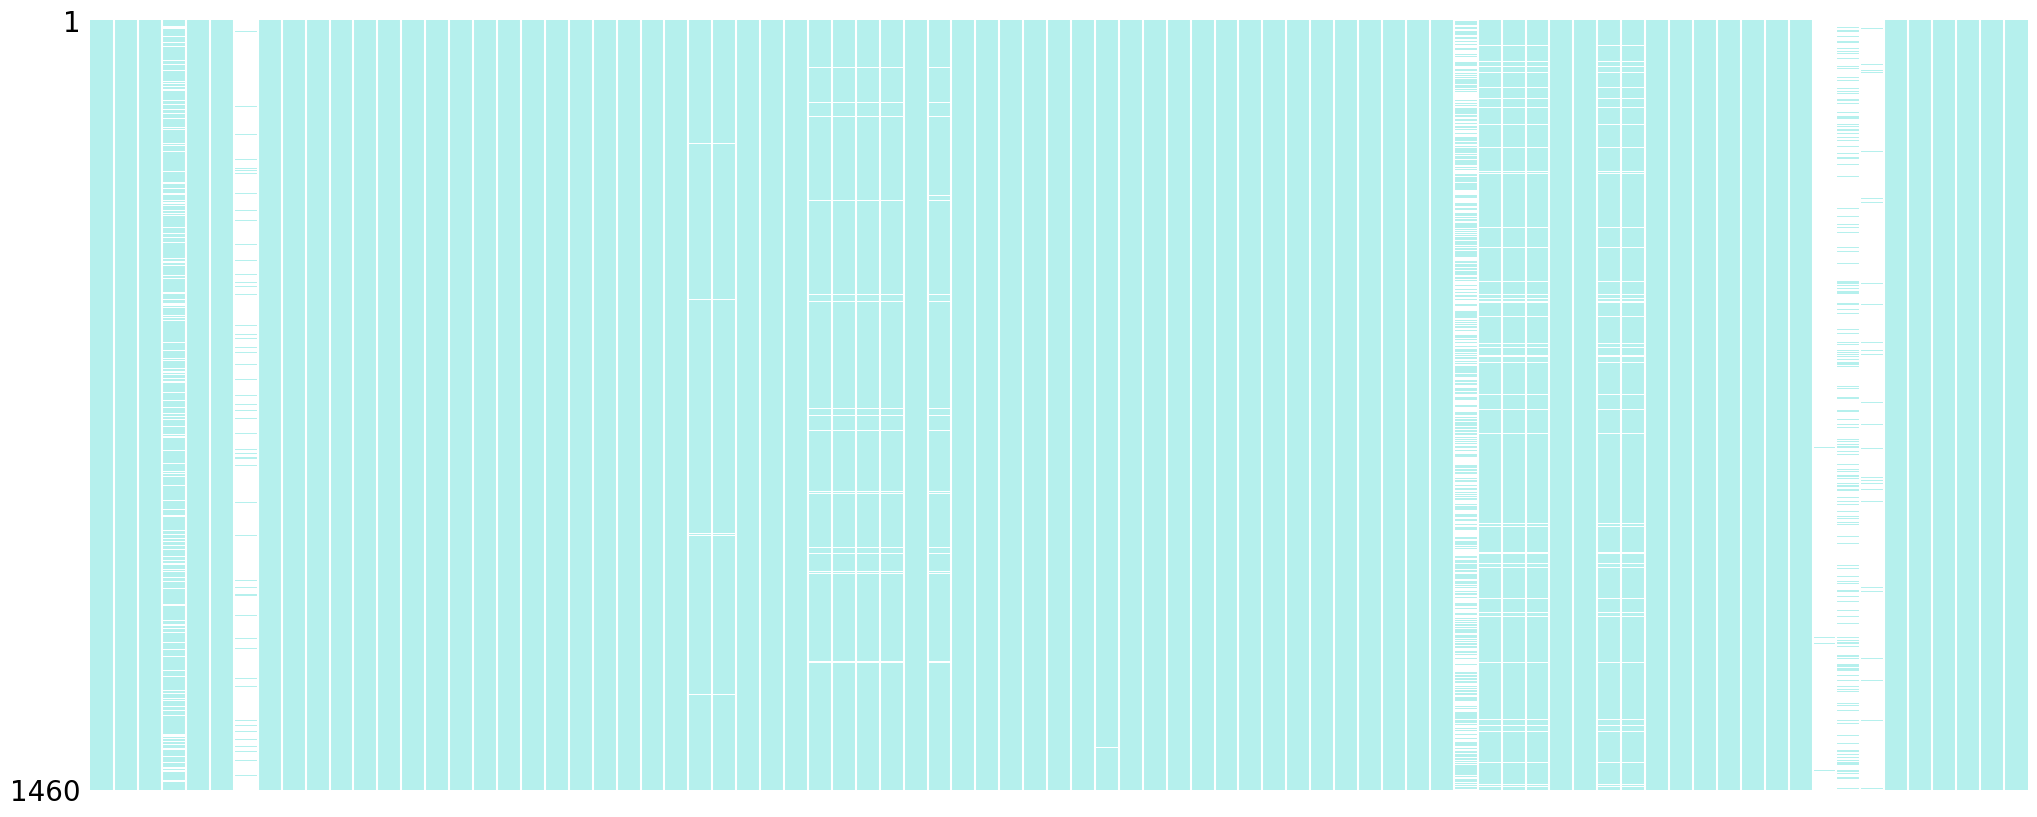

In [6]:
# Overview missing data
fig = msno.matrix(df, sparkline=False,color=( 181/255, 240/255, 237/255 ))
plt.show()

> We have to handle missing data problem

In [10]:
# Chekcing the percentage of Null values in all the columns
missing_values = round(df.isnull().sum()/len(df.index)*100,2).sort_values(ascending=False)[ round(df.isnull().sum()/len(df.index),2) > 0 ] 
print('Percentage of Missing Values in each column is as follows:')
print(missing_values)
print(f'{len(missing_values)} features have missing values')

Percentage of Missing Values in each column is as follows:
PoolQC          99.52
MiscFeature     96.30
Alley           93.77
Fence           80.75
FireplaceQu     47.26
LotFrontage     17.74
GarageYrBlt      5.55
GarageCond       5.55
GarageType       5.55
GarageFinish     5.55
GarageQual       5.55
BsmtFinType2     2.60
BsmtExposure     2.60
BsmtQual         2.53
BsmtCond         2.53
BsmtFinType1     2.53
MasVnrArea       0.55
MasVnrType       0.55
dtype: float64
18 features have missing values


> 5 features have more than 45% missing values.

In [7]:
# check duplicate
df_dup = df
df_dup.drop_duplicates(subset = None, inplace= True)
if df_dup.shape == df.shape:
    print('There have no duplicate')
else:
    print('Some duplicate in this dataset')

There have no duplicate


In [8]:
# Check columns with only one values
columns = list(df.columns)
columns_values_count = {c: len(df[c].value_counts().index) for c in columns}
one_value_column = [c for c,v in columns_values_count.items() if v < 2]
if len(one_value_column) > 0:
    print(f'Columns that have only one values: {one_value_column}')
else:
    print('There is no column with only one value')

There is no column with only one value


In [13]:
# pre-classify type of columns
numerical = df.select_dtypes(include=[np.number])
categorical = df.select_dtypes(include = object)
print('numerical columns:', numerical.columns)
print('categorical columns:', categorical.columns)


numerical columns: Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')
categorical columns Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType

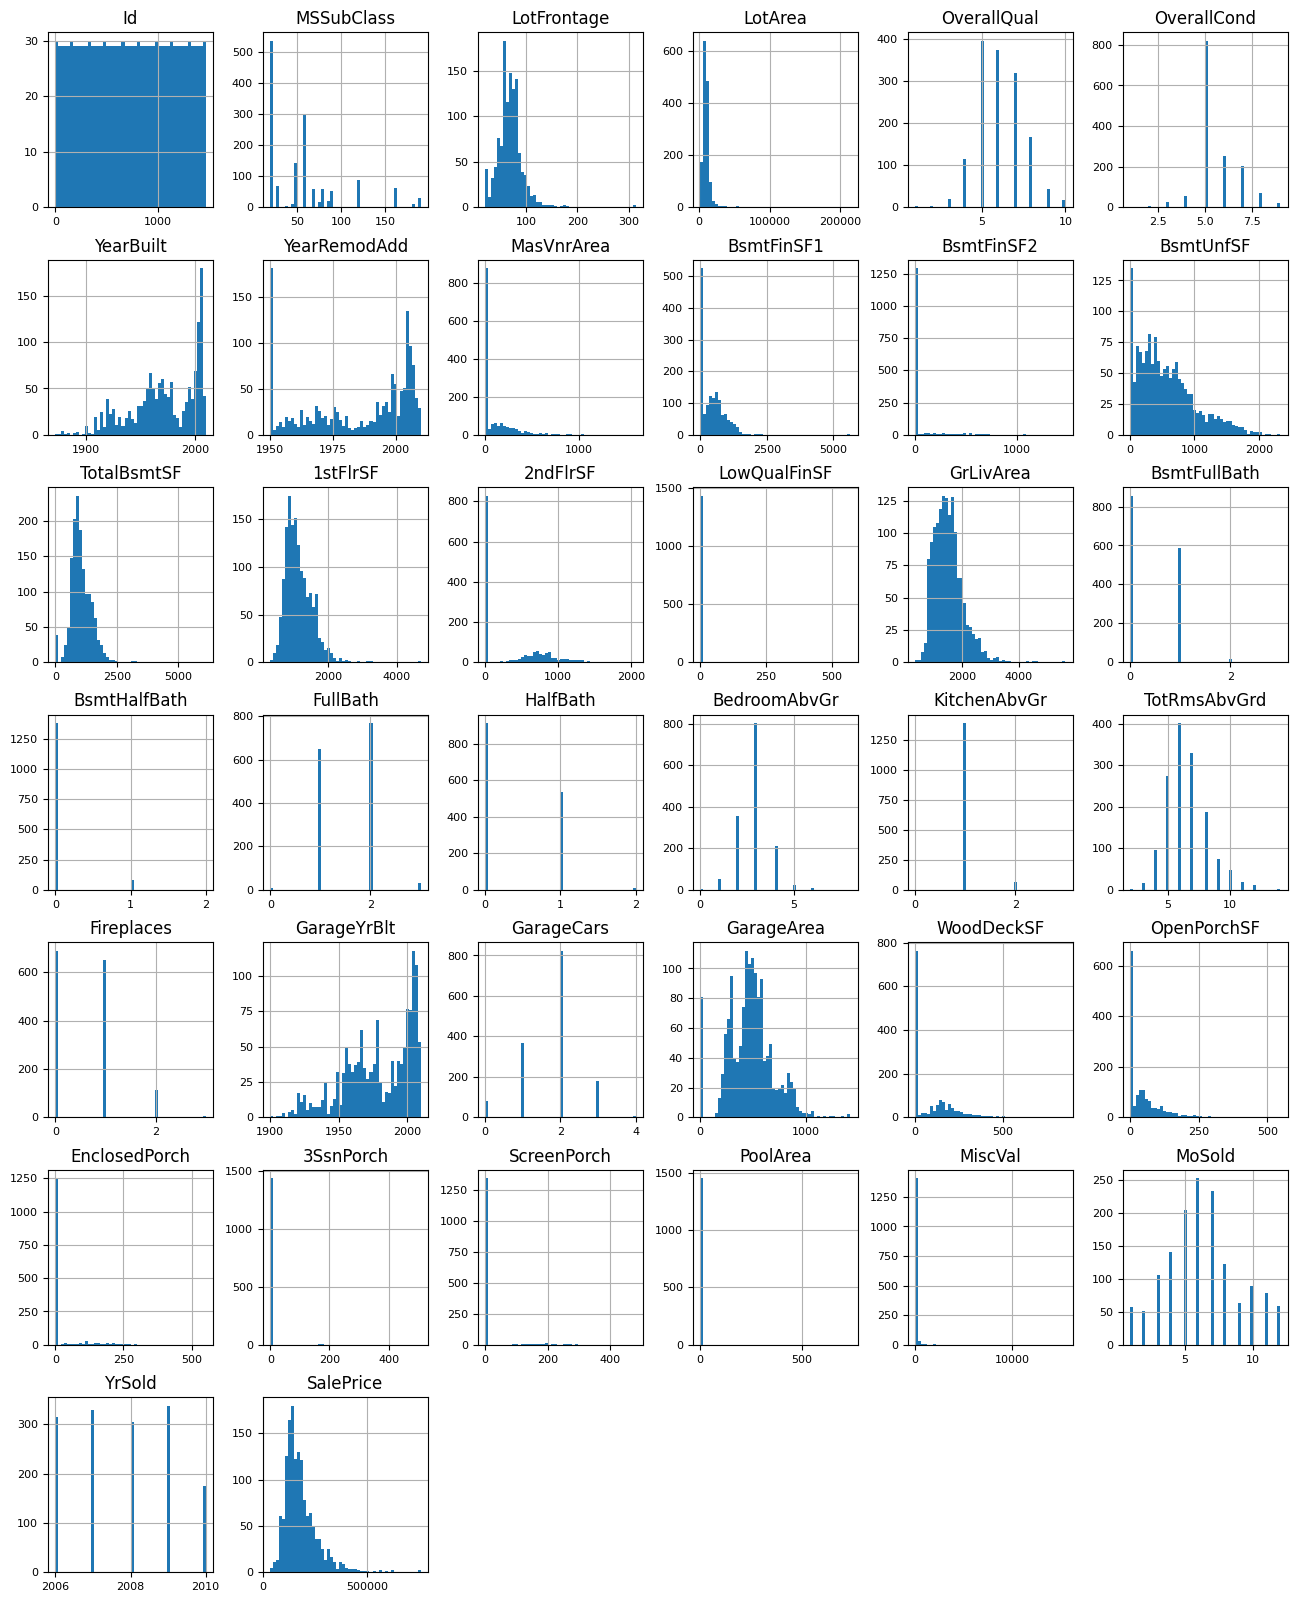

In [14]:
numerical.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)


> 

Observations: 1460
Variables: 81
cat_cols: 53
num_cols: 27
cat_but_car: 1
num_but_cat: 11


array([[<Axes: title={'center': 'Id'}>,
        <Axes: title={'center': 'MSSubClass'}>,
        <Axes: title={'center': 'LotFrontage'}>,
        <Axes: title={'center': 'LotArea'}>,
        <Axes: title={'center': 'OverallQual'}>],
       [<Axes: title={'center': 'YearBuilt'}>,
        <Axes: title={'center': 'YearRemodAdd'}>,
        <Axes: title={'center': 'MasVnrArea'}>,
        <Axes: title={'center': 'BsmtFinSF1'}>,
        <Axes: title={'center': 'BsmtFinSF2'}>],
       [<Axes: title={'center': 'BsmtUnfSF'}>,
        <Axes: title={'center': 'TotalBsmtSF'}>,
        <Axes: title={'center': '1stFlrSF'}>,
        <Axes: title={'center': '2ndFlrSF'}>,
        <Axes: title={'center': 'LowQualFinSF'}>],
       [<Axes: title={'center': 'GrLivArea'}>,
        <Axes: title={'center': 'TotRmsAbvGrd'}>,
        <Axes: title={'center': 'GarageYrBlt'}>,
        <Axes: title={'center': 'GarageArea'}>,
        <Axes: title={'center': 'WoodDeckSF'}>],
       [<Axes: title={'center': 'OpenPorchSF

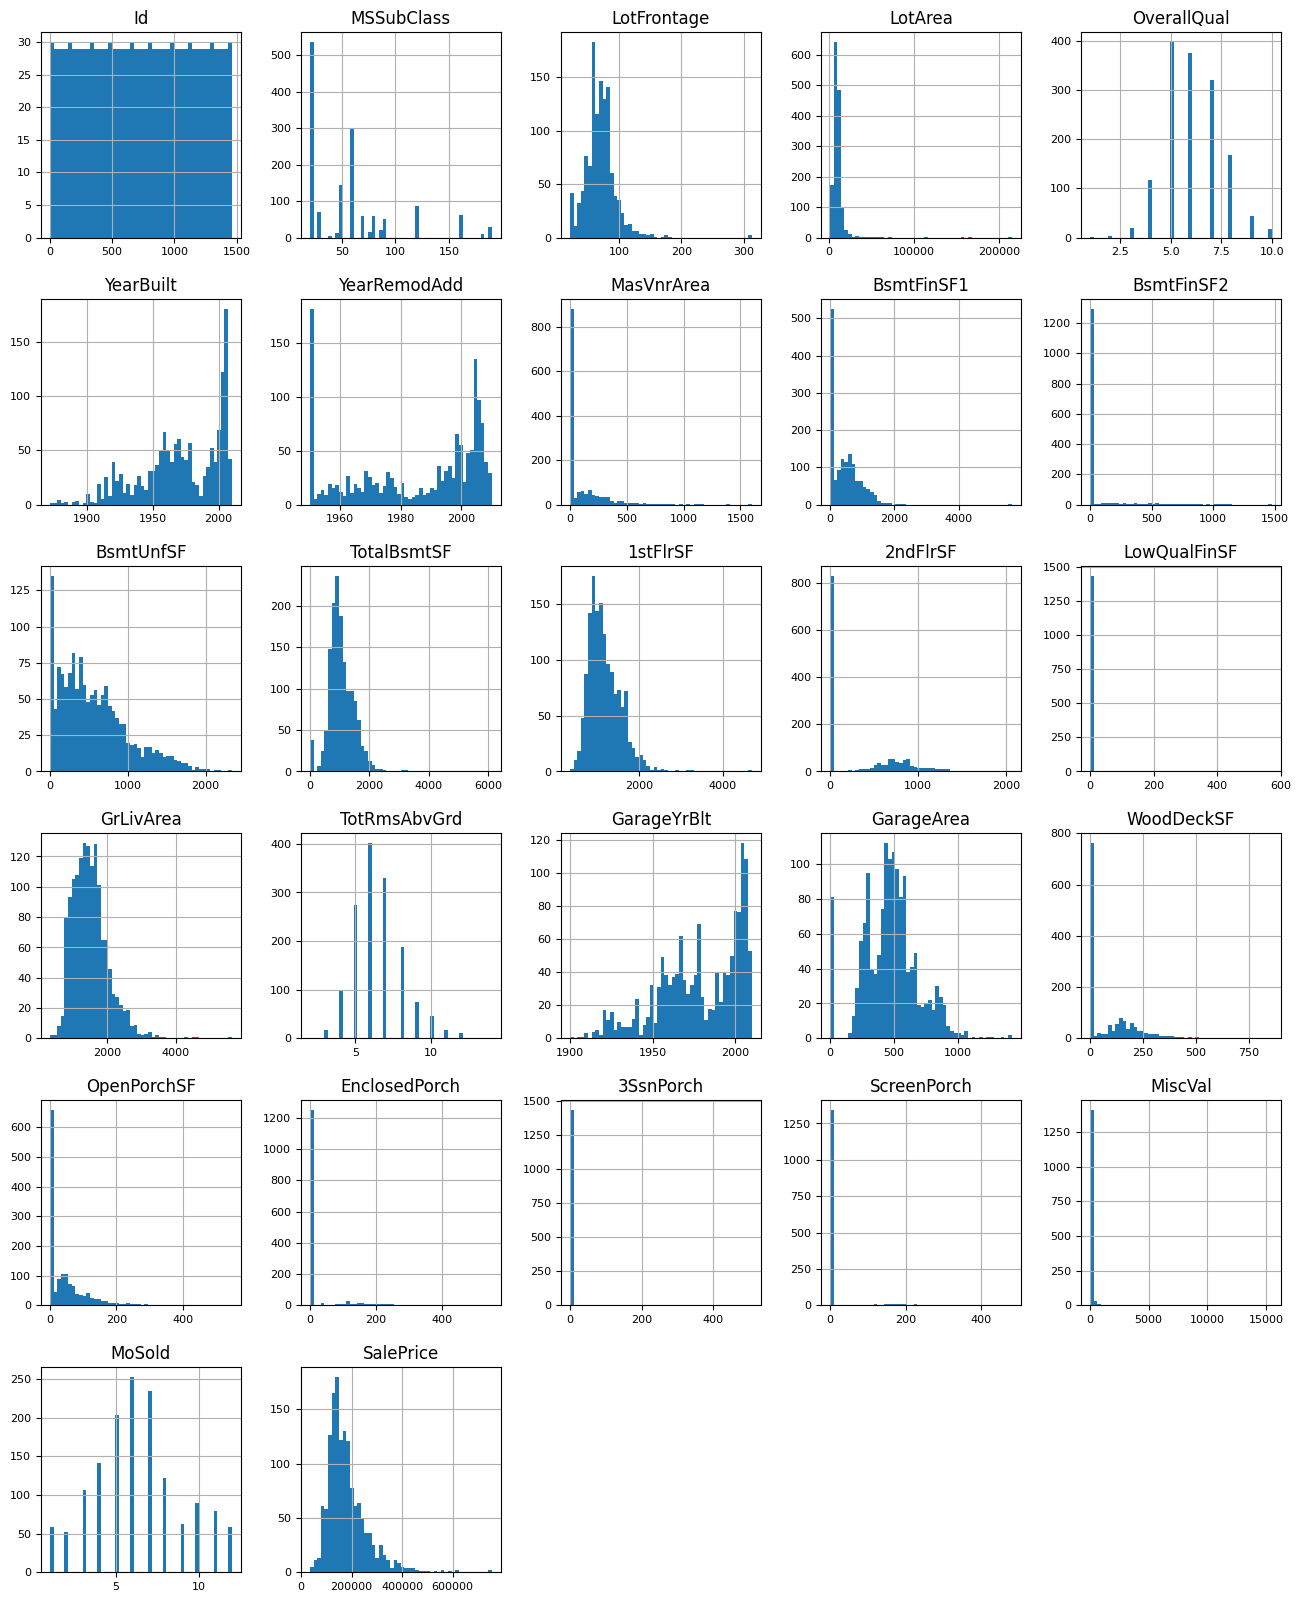

In [22]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)
df[num_cols].hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)


# Data preparation